In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Beta
from biogeme.models import loglogit
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Data/swissmetro.dat', sep='\t')
keep = ((df['PURPOSE']!=1)*(df['PURPOSE']!=3)+(df['CHOICE']==0)) == 0
df = df[keep]
df.loc[:, 'TRAIN_COST'] = df['TRAIN_CO'] * (df['GA']==0)
df.loc[:, 'SM_COST'] = df['SM_CO'] * (df['GA']==0)
df_final = df[['TRAIN_TT', 'TRAIN_COST', 'TRAIN_HE', 'SM_TT', 'SM_COST', 'SM_HE', 'CAR_TT', 'CAR_CO', 'CHOICE']]
df_train, df_test  = train_test_split(df_final, test_size=0.2, random_state=2023)

In [3]:
database_train = db.Database('swissmetro_train', df_train)

globals().update(database_train.variables)

# Parameters to be estimated
ASC_CAR   = Beta('ASC_CAR', 0, None, None, 0)
ASC_SM    = Beta('ASC_SM',  0, None, None, 0)
ASC_TRAIN = Beta('ASC_SBB', 0, None, None, 1)

B_TIME = Beta('B_TIME', 0, None, 0, 0)
B_COST = Beta('B_COST', 0, None, 0, 0)
B_HE   = Beta('B_HE',   0, None, 0, 0)

# Utilities
V_TRAIN = ASC_TRAIN + B_TIME * TRAIN_TT + B_COST * TRAIN_COST + B_HE * TRAIN_HE
V_SM    = ASC_SM    + B_TIME * SM_TT    + B_COST * SM_COST    + B_HE * SM_HE
V_CAR   = ASC_CAR   + B_TIME * CAR_TT   + B_COST * CAR_CO

V = {1: V_TRAIN, 2: V_SM, 3: V_CAR}
av = {1: 1, 2: 1, 3: 1}

# Choice model estimation
logprob = loglogit(V, av, CHOICE)
biogeme = bio.BIOGEME(database_train, logprob)
biogeme.modelName = "SwissmetroMNL"

biogeme.generate_html = False
biogeme.generate_pickle = False

# Estimation with PandasBiogeme

In [4]:
results = biogeme.estimate()

betas = results.getBetaValues()
#results
pandasResults = results.getEstimatedParameters()
print(pandasResults)
print(f"Nbr of observations: {biogeme.database.getNumberOfObservations()}")
print(f"LL(0) = {results.data.initLogLike:.3f}")
print(f"LL(beta) = {results.data.logLike:.3f}")
print(f"rho bar square = {results.data.rhoBarSquare:.3g}")
print(f"Output file: {results.data.htmlFileName}")

            Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CAR  0.115202      0.085998     1.339586  1.803799e-01
ASC_SM   1.238200      0.070874    17.470472  0.000000e+00
B_COST  -0.006709      0.000545   -12.309609  0.000000e+00
B_HE    -0.005371      0.001092    -4.918596  8.716713e-07
B_TIME  -0.001495      0.000389    -3.845705  1.202066e-04
Nbr of observations: 5414
LL(0) = -4863.036
LL(beta) = -4863.036
rho bar square = -0.00103
Output file: None


# Estimation with RUMBooster

In [5]:
from demo_swissmetro import rumb_train

params = {'max_depth': 2, 
            'num_boost_round': 150, 
            'objective':'multiclass',
            'learning_rate': 0.3,
            'verbosity': 1,
            'num_classes': 3,
            'min_sum_hessian': 1e-6,
            'min_data_in_leaf': 1,
            'early_stopping_round':5
            }

rumb_demo = rumb_train(biogeme, params)

c:\Users\nicol\OneDrive - University College London\Documents\PhD - UCL\GBM feature extraction\Multiclass problem\rumbooster.py:1241: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 736, number of negative: 4678
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 3
[LightGBM] [Info] Number of positive: 3288, number of negative: 2126
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 3
[LightGBM] [Info] Number of positive: 1390, number of negative: 4024
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] 

In [6]:
rumb_demo.getweights_v2()

(        Feature   Split point  Left leaf value  Right leaf value  Utility
 0    TRAIN_COST  1.000000e-35         0.115862         -0.058065        0
 1    TRAIN_COST  1.850000e+01         0.000000          0.058065        0
 2    TRAIN_COST  1.000000e-35         0.118272         -0.022115        0
 3    TRAIN_COST  1.850000e+01         0.000000          0.022115        0
 4    TRAIN_COST  1.000000e-35         0.113915         -0.048431        0
 ..          ...           ...              ...               ...      ...
 392      CAR_CO  2.370000e+02        -0.001229         -0.002255        2
 393      CAR_CO  8.900000e+01         0.001229          0.000000        2
 394      CAR_CO  2.370000e+02        -0.001321         -0.002106        2
 395      CAR_CO  2.370000e+02        -0.001294         -0.002070        2
 396      CAR_CO  2.370000e+02        -0.001055         -0.001716        2
 
 [397 rows x 5 columns],
                   Feature             higher_lvl_range   
 0     TRAIN_C

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


c:\Users\nicol\OneDrive - University College London\Documents\PhD - UCL\GBM feature extraction\Multiclass problem\rumbooster.py:864: UserWarning: linewidths is ignored by contourf
  c_plot = ax1.contourf(X, Y, contour_plot, linewidths=0)


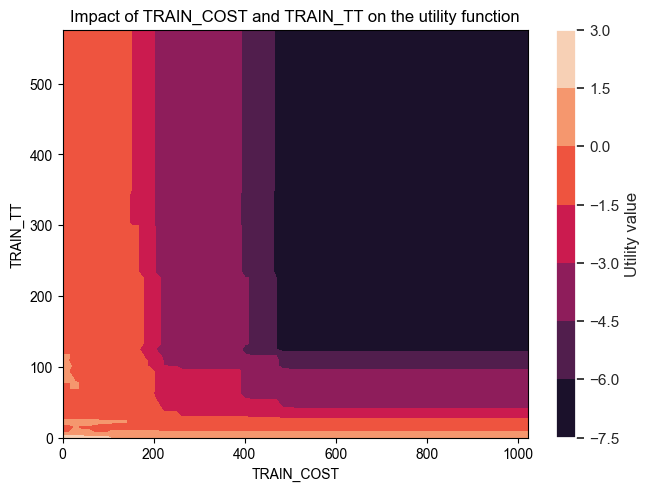

In [7]:
import numpy as np
rumb_demo.plot_2d('TRAIN_COST','TRAIN_TT', np.max(df_train['TRAIN_TT']),np.max(df_train['TRAIN_COST']))

In [6]:
from demo_swissmetro import compare_models

compare_models(biogeme, rumb_demo, df_test, betas)

On SwissMetro, biogeme has a negative CE of 0.910850920538341 and RUMBooster of 0.755409607164759 on the test set


## And we can plot the nonlinear impact of features on the utility function

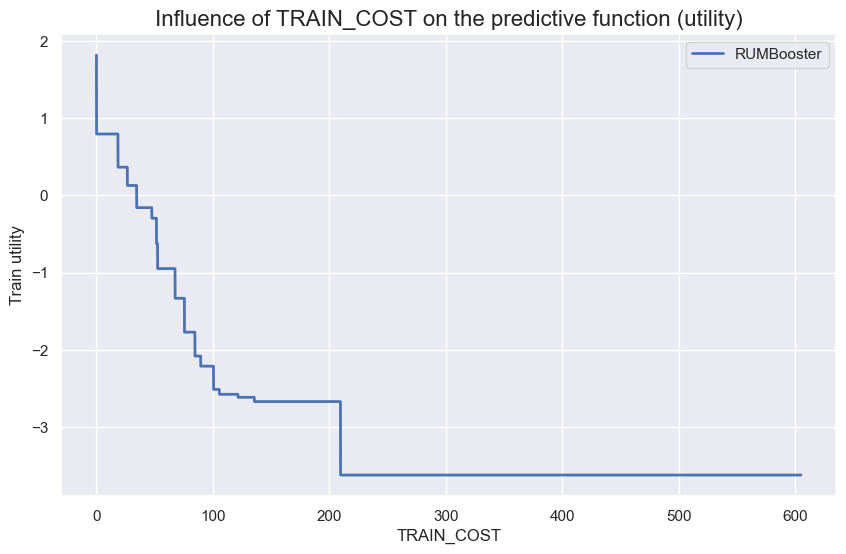

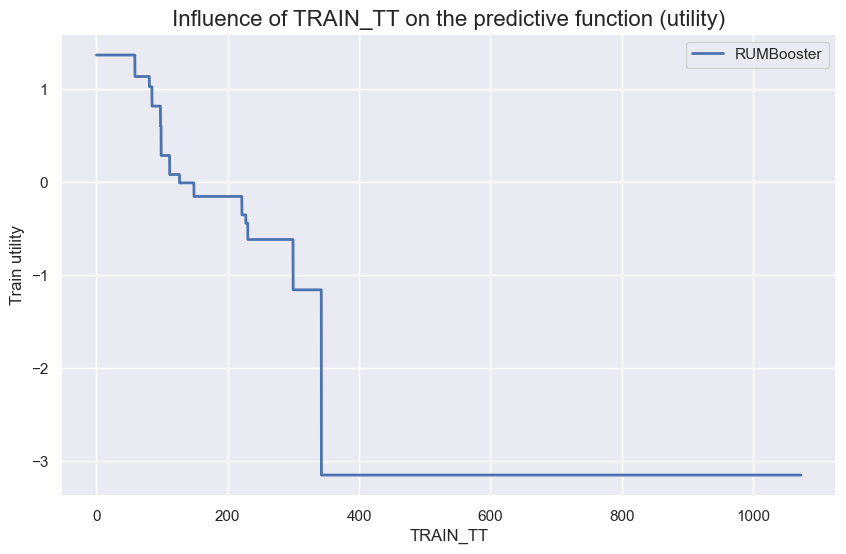

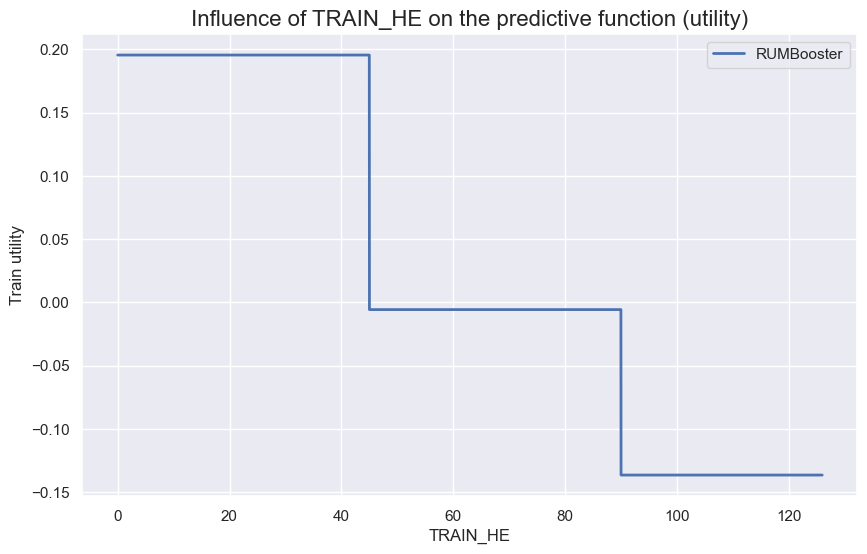

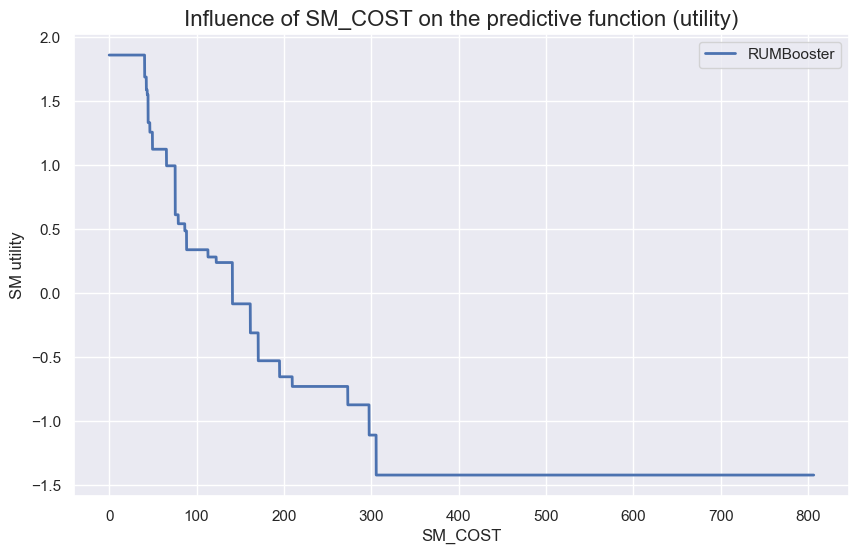

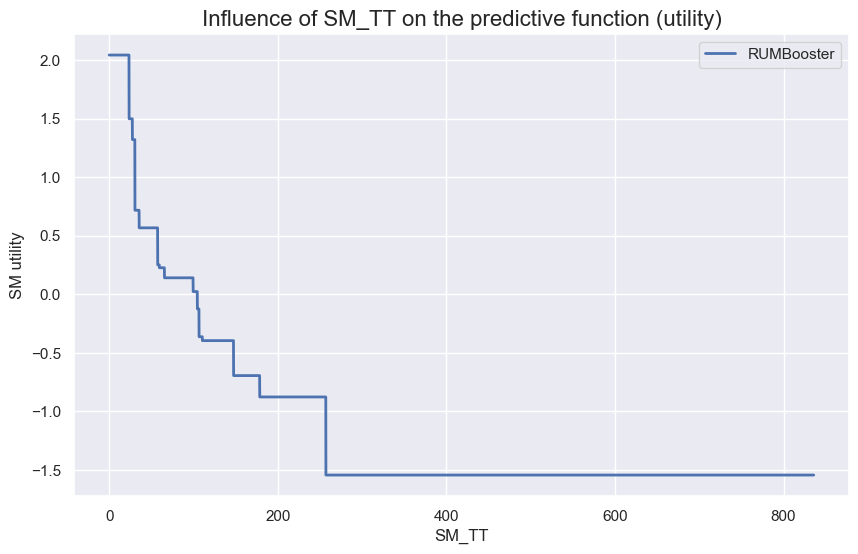

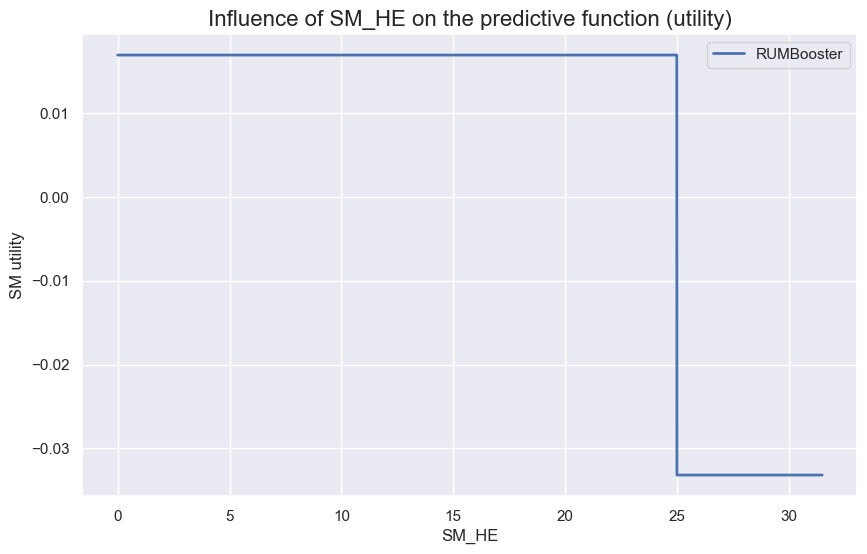

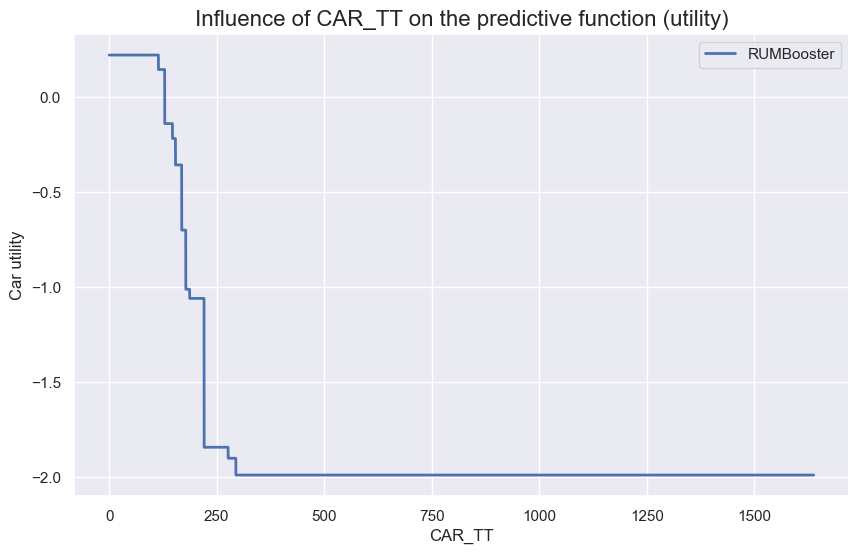

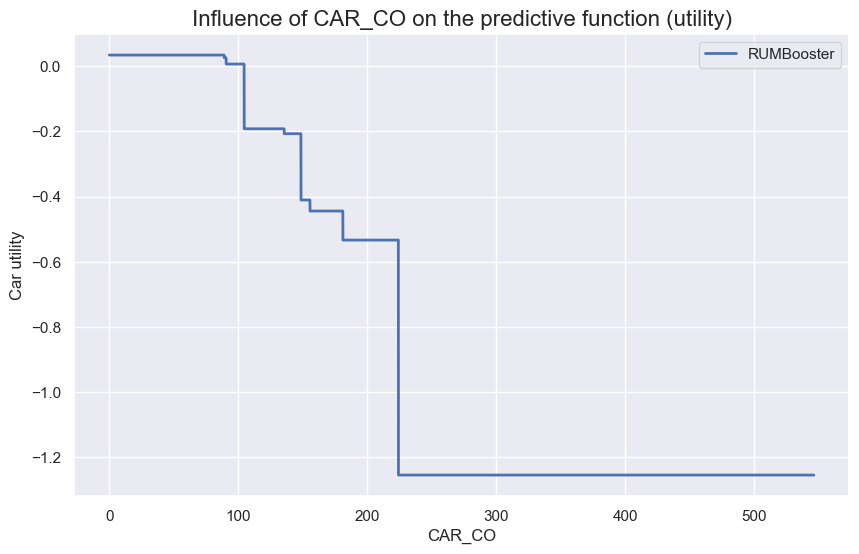

In [7]:
utility_names = {'0': 'Train', '1': 'SM', '2': 'Car'}

rumb_demo.plot_parameters(params, df_train, utility_names)